In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Input, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, Adadelta
from keras.utils.np_utils import to_categorical
from keras.applications.xception import *
from keras.utils import np_utils

Using TensorFlow backend.


# Define model

In [2]:
img_size = 299 #Needed for the Xception model
base_model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3), include_top=False)

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

# Compiler

In [3]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Learning rate annealer

In [4]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

# Data directories

In [5]:

train_dir = os.path.join(os.getcwd(),'data/train/train')
test_dir = os.path.join(os.getcwd(),'data/test/test')

# Species

In [6]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']

for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


# Training data

In [7]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append([train_dir+'/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)


Training Data:  (4750, 3)


# Image Pre-processing

In [8]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity=35
    lower_green = np.array([60 - sensitivity, 100, 50])
    upper_green = np.array([60 + sensitivity, 255, 255])
    mask = cv2.inRange(image_hsv, lower_green, upper_green)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# Load training data

In [9]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(img_size,img_size))
    img_segment = segment_plant(img)
    img_sharpen = sharpen_image(img_segment)
    x_train.append(img_sharpen)

x_train = np.array(x_train)

CPU times: user 54.4 s, sys: 2.62 s, total: 57 s
Wall time: 1min 4s


# Sample image

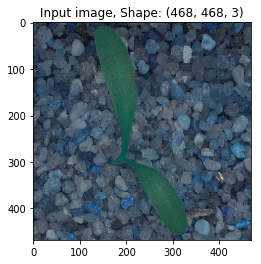

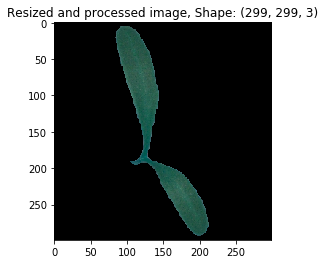

In [10]:
# Input image
index=4444
Input_image = cv2.imread(train['file'][index])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized and processed image
plt.imshow(x_train[index])
plt.title('Resized and processed image, Shape: '+str(x_train[index].shape))
plt.show()

# One hot encoding

In [11]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))

# Train, validation split

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=1)

# Image Data generator


In [13]:
datagen = ImageDataGenerator(rotation_range=60,

width_shift_range=0.3,

height_shift_range=0.3,

zoom_range=0.3,

horizontal_flip=True,

vertical_flip=True)

In [14]:
datagen.fit(x_train)

# Fit the model

In [15]:
batch_size = 32
epochs = 50

training=model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), validation_data = (x_val,y_val),steps_per_epoch=len(x_train)//batch_size, epochs=epochs, verbose=1, callbacks=[learning_rate_reduction])

model.save_weights('Xception_v2.h5')


Epoch 1/50
133/133 [==============================] - 157s 1s/step - loss: 0.8482 - acc: 0.7279 - val_loss: 1.9837 - val_acc: 0.5958
Epoch 2/50
133/133 [==============================] - 143s 1s/step - loss: 0.5255 - acc: 0.8312 - val_loss: 1.6156 - val_acc: 0.6611
Epoch 3/50
133/133 [==============================] - 143s 1s/step - loss: 0.3895 - acc: 0.8675 - val_loss: 1.0895 - val_acc: 0.7495
Epoch 4/50
133/133 [==============================] - 143s 1s/step - loss: 0.3554 - acc: 0.8809 - val_loss: 2.2781 - val_acc: 0.5747
Epoch 5/50
133/133 [==============================] - 143s 1s/step - loss: 0.3585 - acc: 0.8866 - val_loss: 0.3703 - val_acc: 0.8632
Epoch 6/50
133/133 [==============================] - 143s 1s/step - loss: 0.3008 - acc: 0.9021 - val_loss: 0.6006 - val_acc: 0.8484
Epoch 7/50
133/133 [==============================] - 143s 1s/step - loss: 0.2566 - acc: 0.9134 - val_loss: 0.3571 - val_acc: 0.8842
Epoch 8/50
133/133 [==============================] - 143s 1s/step - 

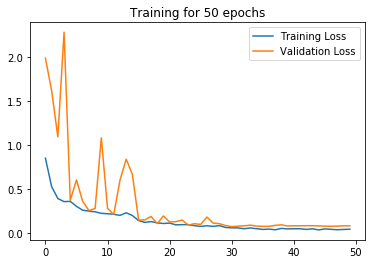

In [16]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

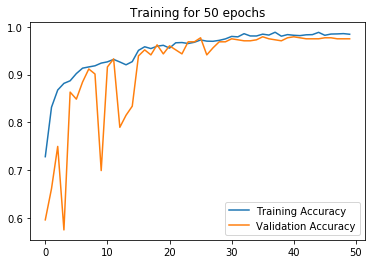

In [17]:
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Load Test Data

In [23]:
%%time

test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append([test_dir+'/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print('Test Data: ',test.shape)

Test Data:  (794, 1)
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 8.44 ms


In [19]:
%%time

x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(img_size,img_size))
    img_segment = segment_plant(img)
    img_sharpen = sharpen_image(img_segment)
    x_test.append(img_sharpen)

x_test = np.array(x_test)

CPU times: user 7.38 s, sys: 332 ms, total: 7.71 s
Wall time: 8.91 s


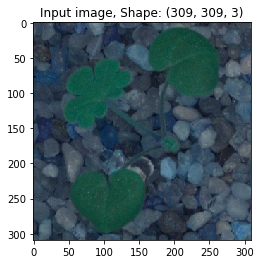

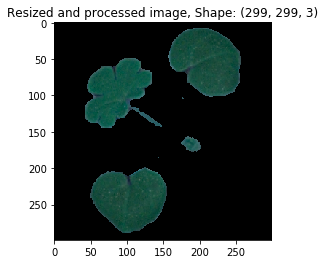

In [20]:
# Input image
index=4
Input_image = cv2.imread(test['file'][index])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized and processed image
plt.imshow(x_test[index])
plt.title('Resized and processed image, Shape: '+str(x_test[index].shape))
plt.show()

# Predictions on the test set

In [21]:
Pred_labels = np.argmax(model.predict(x_test),axis = 1)

In [22]:
sample_submission = pd.read_csv('data/sample_submission.csv')
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 

submission.to_csv('submission_v4.csv', index=False)
print(submission.head())


            file                    species
0  0021e90e4.png  Small-flowered Cranesbill
1  003d61042.png                    Fat Hen
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet
